In [1]:
import pandas as pd
import numpy as np

def decay(t0,
          t,
          alpha,
          tau):
    if type(alpha) == float:
        return np.exp(-(t-t0)/tau)
    elif len(alpha) > 1: # probably CO2
        assert len(alpha) == len(tau) + 1
        return alpha[0] + sum(aa * np.exp(-(t-t0)/tt) for aa,tt in zip(alpha[1:],tau))

def concentration(emission_profile, # list of coordinates (t,y), t is strictly increasing
                  tau,
                  alpha=1.0,
                  step=1,
                  c_0=0.0,
                  t_max=2100):
    
    '''
    
    
    
    '''
    
    if type(alpha) == float:
        CO2 = False
    else:
        CO2 = True
    
    n_points = len(emission_profile)
    assert n_points >= 2
    
    # initialize
    T0 = emission_profile[0][0]
    c = np.zeros(shape=t_max-T0+1)
    
    for i in range(n_points-1):
        
        # extract the variables that we need
        t0, y0 = emission_profile[i]
        t1, y1 = emission_profile[i+1]
        
        # create the time series for the interval of interest
        time = np.arange(t0,t1+1)
        
        # calculate the linear coefficients
        a = (y1-y0)/(t1-t0)
        b = (y0*t1-y1*t0)/(t1-t0)
        
        print(t0,t1,y0,y1,a,b)
        
        
        if CO2:
            # calculate the decay function
            d = decay(t0,time,alpha,tau) # this should be fine (integrated until t_max)
            
            c_i = list(alpha[0]*(a*(time**2-t0**2)/2+b*(time-t0)) + \
                sum(aa*tt*(a*((tt-t0)*np.exp(-(time-t0)/tt)+time-tt) + b*(1-np.exp(-(time-t0)/tt))) for aa,tt in zip(alpha[1:],tau)))
            
        else:
            # calculate the decay function
            d = np.exp(-(time-t0)/tau)
        
            # calculate the dynamic concentrations
            c_i = list(c_0*d + # any residue from a previous period \
                tau*(a*((tau-t0)*d+time-tau) + b*(1-d))) # plus the ongoing emissions
        
#    if t1 < t_max:
        c_0 = c_i.pop()
        time_to_end = np.arange(t1,t_max+1)
        c_i.extend(c_0*decay(t1,time_to_end,alpha,tau))
        # finally pop the last value, that's the start of the next period
        
        # store it
        c += np.array([0.] * (t0-T0) + c_i)
    
    # if we want to calculate the concentration beyond the last t, then let's do that
        print(c.shape)
    
    emissions = list(zip(*emission_profile))
    
    time = np.arange(T0,t_max+1)
    concentration_series = pd.Series(c, index=time)
    
    emission_series = pd.Series(emissions[1],
                                index=emissions[0]).reindex(time).interpolate(limit_area='inside')
    
    return emission_series, concentration_series


In [37]:
a_x_i = pd.read_csv('GHG_property_table.csv',index_col=0)
a_x_i['Lifetime (Years)'] = pd.to_numeric(a_x_i['Lifetime (Years)'],errors='coerce')
a_x_i

,Chemical Formula,Lifetime (Years),Radiative Efficiency (W m-2 ppb-1),AGWP 20-year (W m-2 yr kg-1),GWP 20-year,AGWP 100-year (W m-2 yr kg-1),GWP 100-year,AGTP 20-year (K kg-1),GTP 20-year,AGTP 50-year (K kg-1),GTP 50-year,AGTP 100-year (K kg-1),GTP 100-year,Molar mass (g mol-1),Correction
"Acronym, Common Name or Chemical Name",,,,,,,,,,,,,,,
"(E)-1-Chloro-3,3,3-trifluoroprop-1-ene",trans-CF3CH=CHCl,0.07,0.04,1.370000e-13,5,1.370000e-13,1,1.090000e-15,2,1.540000e-16,<1,1.120000e-16,<1,130.49,1.0
(E)-HFC-1225ye,CF3CF=CHF(E),0.01,0.01,7.250000e-15,<1,7.250000e-15,<1,5.770000e-17,<1,8.140000e-18,<1,5.950000e-18,<1,132.03,1.0
(E)-HFC-1234ze,trans-CF3CH=CHF,0.04,0.04,8.740000e-14,4,8.740000e-14,<1,6.980000e-16,<1,9.820000e-17,<1,7.180000e-17,<1,114.04,1.0
(Trifluoromethyl) sulphur pentafluoride,SF5CF3,800.00,0.59,3.360000e-10,13500,1.600000e-09,17400,9.930000e-12,14500,1.100000e-11,17800,1.110000e-11,20200,196.06,1.0
(Z)-HFC-1225ye,CF3CF=CHF(Z),0.02,0.02,2.140000e-14,<1,2.140000e-14,<1,1.700000e-16,<1,2.400000e-17,<1,1.760000e-17,<1,132.03,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sevoflurane (HFE-347mmz1),(CF3)2CHOCH2F,2.20,0.32,1.980000e-11,795,1.980000e-11,216,2.060000e-13,302,8.240000e-13,38,1.640000e-14,30,200.05,1.0
Sulphur hexafluoride,SF6,3200.00,0.57,4.370000e-10,17500,2.160000e-09,23500,1.290000e-11,18900,1.470000e-11,23800,1.540000e-11,28200,146.06,1.0
Sulphuryl fluoride,SO2F2,36.00,0.20,1.710000e-10,6840,3.760000e-10,4090,4.580000e-12,6690,2.550000e-12,4140,9.010000e-13,1650,102.06,1.0


In [38]:
a_x_i['Lifetime (Years)']['Methane']

12.4

In [107]:
atm_mass   = 5.1480e18 # kg
atm_mol    = 29.80 # g/mol

# CO2
alpha_CO2 = [0.217278,0.224037,0.282381,0.276303]
tau_CO2   = [394.409,36.5393,4.30365]
rf_ppb_CO2 = a_x_i['Radiative Efficiency (W m-2 ppb-1)']['Carbon dioxide']
MM_CO2 = a_x_i['Molar mass (g mol-1)']['Carbon dioxide']

# CH4
alpha_CH4 = 1.
tau_CH4   = a_x_i['Lifetime (Years)']['Methane']
rf_ppb_CH4 = a_x_i['Radiative Efficiency (W m-2 ppb-1)']['Methane']
MM_CH4 = a_x_i['Molar mass (g mol-1)']['Methane']

# profile in kg
profile = ((2000, 20),
           (2010, 30),
           (2020, 35),
           (2030, 38),
           (2040, 40),
           (2050, 40))

profile = ((2000, 20),
           (2010, 30),
           (2020, 40))
#
#profile = ((2000, 20),
#           (2020, 40))

#profile = ((2000, 50),
#           (2050, 30))

profile_CO2 = ((2000, 40e12), # in Gt
          (2200, 40e12))
profile_CH4 = ((2000, .4e12), # in Gt
          (2200, .4e12))

a_CO2,b_CO2   = concentration(profile_CO2,
                      alpha=alpha_CO2,
                      tau=tau_CO2,
                      c_0=275,
                             t_max=2200)

a_CH4,b_CH4   = concentration(profile_CH4,
                      alpha=alpha_CH4,
                      tau=tau_CH4,
                      c_0=275,
                             t_max=2200)

results = pd.concat([a_CO2,
                     a_CH4,
          rf_ppb_CO2/MM_CO2 * atm_mol/atm_mass * 1e9 * b_CO2,
          
          rf_ppb_CH4/MM_CH4 * atm_mol/atm_mass * 1e9 * b_CH4],
          keys = pd.MultiIndex.from_product([['Emissions','Radiative forcing'],['CO2','CH4']]),
    axis=1)


2000 2200 40000000000000.0 40000000000000.0 0.0 40000000000000.0
(201,)
2000 2200 400000000000.0 400000000000.0 0.0 400000000000.0
(201,)


In [108]:
results

Emissions               Radiative forcing              
               CO2           CH4               CO2           CH4
2000  4.000000e+13  4.000000e+11          0.000000  3.602572e-11
2001  4.000000e+13  4.000000e+11          0.069638  5.034378e-02
2002  4.000000e+13  4.000000e+11          0.135008  9.678697e-02
2003  4.000000e+13  4.000000e+11          0.196889  1.396318e-01
2004  4.000000e+13  4.000000e+11          0.255902  1.791570e-01
...            ...           ...               ...           ...
2196  4.000000e+13  4.000000e+11          6.389718  6.497729e-01
2197  4.000000e+13  4.000000e+11          6.415285  6.497729e-01
2198  4.000000e+13  4.000000e+11          6.440825  6.497729e-01
2199  4.000000e+13  4.000000e+11          6.466337  6.497729e-01
2200  4.000000e+13  4.000000e+11          6.491816  6.497729e-01

[201 rows x 4 columns]

<AxesSubplot:title={'center':'Warming (W m-2)'}>

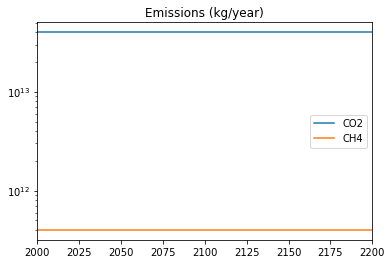

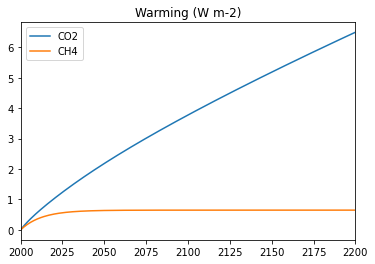

In [109]:
results['Emissions'].plot(title='Emissions (kg/year)',logy=True)
results['Radiative forcing'].plot(title='Warming (W m-2)')